# Voltage‑dependent dose–response analysis
A step‑by‑step notebook that mirrors the procedure used in *Tauber & Ben‑Chaim 2022*.

Fill in your own data (CSV or manual entry) and run each cell one‑by‑one.
Feel free to save this notebook under a new name for your experiments.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
plt.rcParams['figure.dpi'] = 120  # sharper plots


## 1  Load or paste your normalised data
Create a CSV with **three columns**:
* `holding` – the holding potential in mV (e.g. -80, -10, +40 …)
* `conc_nM` – concentration in **nM** (numeric)
* `resp` – normalised response (0–1)

Example rows:
```csv
holding,conc_nM,resp
-80,1,0.05
-80,10,0.45
-10,10,0.28
```
If you already have a DataFrame in memory, skip the next cell.

In [66]:
# ------------------------------------------------------------------
# 0.  Convert the wide “Patch Data” sheet ➞ tidy long table
# ------------------------------------------------------------------
import pandas as pd, re, numpy as np, pathlib

raw_file = "patch_data.xlsx"   # <-- put your filename here
raw = pd.read_excel(raw_file, header=None)          # read *exactly* as laid out

# ── locate the “Normalized” block ───────────────────────────────────────
first_row = raw.iloc[0]
norm_start = first_row[first_row.eq("Normalized")].index
if len(norm_start) == 0:
    raise ValueError("Couldn’t find the header cell 'Normalized'.")
norm_col0 = norm_start[0]

# take columns whose second-row header contains “nM”
norm_cols = [c for c in range(norm_col0, raw.shape[1])
             if isinstance(raw.iloc[1, c], str) and "nM" in raw.iloc[1, c]]

# concentration labels (e.g. '1nM', '10nM'…)
conc_labels = raw.iloc[1, norm_cols].tolist()

# ── build tidy records ─────────────────────────────────────────────────
tidy_rows = []
data = raw.iloc[2:]                       # actual data start on row index 2
for _, r in data.iterrows():
    holding = r[1]                        # column 1 = Holding Potential
    if pd.isna(holding):
        continue
    for c_idx, c_label in zip(norm_cols, conc_labels):
        resp = r[c_idx]
        if pd.isna(resp):                 # skip blanks
            continue
        # force numeric
        try:
            resp = float(resp)
        except ValueError:
            continue
        conc_nM = int(re.findall(r"\d+", c_label)[0])   # '10nM' → 10
        tidy_rows.append({"holding": float(holding),
                          "conc_nM": conc_nM,
                          "resp": resp})

df = (pd.DataFrame(tidy_rows)
        .sort_values(["holding", "conc_nM"])
        .reset_index(drop=True))

print("Tidy dose-response table ready for fitting:")
display(df.head())

# optional: write to CSV for record-keeping
df.to_csv("dose_tidy.csv", index=False)


Tidy dose-response table ready for fitting:


,holding,conc_nM,resp
0,-80.0,0,0.0
1,-80.0,0,0.0
2,-80.0,0,0.0
3,-80.0,0,0.0
4,-80.0,0,0.0


In [67]:
# Replace 'my_data.csv' with your file path
df = pd.read_csv('dose_tidy.csv')
# Uncomment below to preview
# df.head()


In [68]:
df.head()

,holding,conc_nM,resp
0,-80.0,0,0.0
1,-80.0,0,0.0
2,-80.0,0,0.0
3,-80.0,0,0.0
4,-80.0,0,0.0


## 2  Define the Hill equation

In [69]:
def hill(x, ec50, nH=1.0, top=1.0, bottom=0.0):
    """Four-parameter logistic with fixed top/bottom."""
    return bottom + (top-bottom) * (x**nH) / (x**nH + ec50**nH)


## 3  Fit each voltage separately

In [70]:
results = {}      # will hold EC50 values keyed by holding potential
rss     = {}      # will hold residual sum-of-squares keyed the same way

for V in df['holding'].unique():     # iterate over each distinct voltage
    x = df.loc[df.holding==V, 'conc_nM'].values   # concentrations for this V
    y = df.loc[df.holding==V, 'resp'].values      # responses   for this V

    # ---- Non-linear least-squares fit ------------------------------
    # • hill(x, ec50) is our model (Hill slope fixed at 1).
    # • lambda x,e: hill(x,e) tells curve_fit “fit ONE parameter = e”.
    # • bounds=(0,∞) constrains EC50 to positive values.
    popt, _ = curve_fit(lambda x,e: hill(x, e), x, y, bounds=(0, np.inf))
    ec50 = popt[0]                    # popt is a 1-element array

    results[V] = ec50                # store EC50 for this voltage

    # ---- Compute residual sum-of-squares ---------------------------
    residuals = y - hill(x, ec50)     # y_i − ŷ_i
    rss[V] = np.sum(residuals**2)     # Σ(residual²)

# Pretty-print what we found
print("Separate-fit EC50 (nM):")
for V, ec in results.items():
    print(f"  {V:+} mV   {ec:.2f}")


Separate-fit EC50 (nM):
  -80.0 mV   10.14
  -10.0 mV   37.58


## 4  Extra‑sum‑of‑squares F‑test (are EC₅₀s different?)

In [71]:
# --- Extra-sum-of-squares F-test: are the curves (EC50 values) different? ---

x_all = df['conc_nM'].values
y_all = df['resp'].values

# Fit a single (global) Hill curve — one shared EC50
ec50_global, _ = curve_fit(lambda x, e: hill(x, e), x_all, y_all,
                           bounds=(0, np.inf))
rss_global = np.sum((y_all - hill(x_all, ec50_global))**2)

# Degrees-of-freedom bookkeeping
k_sep = len(results)          # parameters in the separate model (one EC50 per voltage)
k_glob = 1                    # parameters in the global model (shared EC50)
df_num = k_sep - k_glob       # numerator d.f.  = # extra parameters
df_den = len(y_all) - k_sep   # denominator d.f. = N − parameters_separate

# Residual sum-of-squares for the separate fits
RSS_sep = sum(rss.values())

# F statistic
F = ((rss_global - RSS_sep) / df_num) / (RSS_sep / df_den)

# p-value
p = 1 - stats.f.cdf(F, df_num, df_den)

print(f'F = {F:.3f},  p = {p:.4e}')


F = 28.833,  p = 1.0329e-06


## 5  Plot curves + data

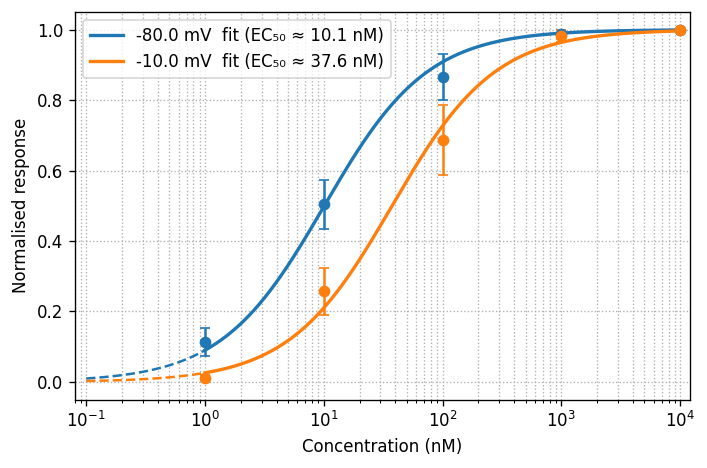

In [72]:
# ------------------------------------------------------------------
# 0.  Assumptions
# ------------------------------------------------------------------
# • `df` is a pandas DataFrame with columns:
#       holding   — holding potential (mV)
#       conc_nM   — agonist concentration (nM, can include 0)
#       resp      — normalised response (0–1)
# • `hill(x, ec50, nH=1, top=1, bottom=0)` is already defined
# ------------------------------------------------------------------


# ------------------------------------------------------------------
# 1.  Collapse replicates → mean ± SEM   (exclude 0-nM rows for fitting)
# ------------------------------------------------------------------
stats_df = (
    df[df['conc_nM'] > 0]                       # non-zero only
      .groupby(['holding', 'conc_nM'])
      .agg(mean_resp=('resp', 'mean'),
           sem_resp =('resp', lambda x: x.std(ddof=1)/np.sqrt(len(x))))
      .reset_index()
)


# ------------------------------------------------------------------
# 2.  Fit EC50 to the mean points of each holding potential
# ------------------------------------------------------------------
EC50 = {}
for V in stats_df['holding'].unique():
    sub = stats_df[stats_df['holding'] == V]
    popt, _ = curve_fit(lambda x, e: hill(x, e),
                        sub['conc_nM'].values,
                        sub['mean_resp'].values,
                        bounds=(0, np.inf))
    EC50[V] = popt[0]


# ------------------------------------------------------------------
# 3.  Plot: mean ± SEM and curve fit (plus one extra decade lower)
# ------------------------------------------------------------------
x_min   = stats_df['conc_nM'].min()           # smallest non-zero conc
x_max   = stats_df['conc_nM'].max()
x_lower = x_min / 10                          # one log-decade left

plt.figure(figsize=(6, 4))
color_cycle = plt.cm.tab10.colors            # distinct colours

for V, color in zip(sorted(EC50.keys()), color_cycle):
    # ----- dashed extrapolation below measured range -----
    x_left = np.logspace(np.log10(x_lower), np.log10(x_min), 100)
    plt.semilogx(x_left, hill(x_left, EC50[V]), ls='--', lw=1.5, color=color)

    # ----- solid curve over measured range -----
    x_main = np.logspace(np.log10(x_min), np.log10(x_max), 600)
    plt.semilogx(x_main, hill(x_main, EC50[V]), lw=2, color=color,
                 label=f'{V:+} mV  fit (EC₅₀ ≈ {EC50[V]:.1f} nM)')

    # ----- mean ± SEM points -----
    sub = stats_df[stats_df['holding'] == V]
    plt.errorbar(sub['conc_nM'], sub['mean_resp'], yerr=sub['sem_resp'],
                 fmt='o', ms=6, capsize=3, color=color)

plt.xlabel('Concentration (nM)')
plt.ylabel('Normalised response')
plt.xlim(x_lower * 0.8, x_max * 1.2)
plt.ylim(-0.05, 1.05)
plt.grid(True, which='both', ls=':')
plt.legend()
plt.tight_layout()
plt.show()
